In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import joblib

warnings.filterwarnings('ignore')

# Load dataset
data_test = pd.read_csv('/content/drive/MyDrive/Train AI/test_data.csv')
data_train = pd.read_csv('/content/drive/MyDrive/Train AI/train_data.csv')

data_test1 = data_test.dropna()
data_train1 = data_train.dropna()

#print("Số lượng trước khi lọc các cột:", data_non_null.shape[0])
#print('\n')

# Xử lý dữ liệu
X_te = data_test1.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_te = data_test1['aws']
X_tr = data_train1.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_tr = data_train1['aws']

# Apply min-max scaling
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_te)
X_train_scaled = scaler.fit_transform(X_tr)


# Thiết lập TabNet
tabnet_model = TabNetRegressor( n_d=8,
                                n_a=8,
                                n_steps=3,
                                gamma=1.3,
                                cat_idxs=[],  # Nếu có biến phân loại, thêm chỉ số cột tại đây
                                cat_dims=[],  # Kích thước của các biến phân loại
                                cat_emb_dim=1)

# Cross-validation với mô hình TabNet
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mae_scores = []
mse_scores = []
r2_scores = []

checkpoint_dir = '/content/drive/MyDrive/Train AI/save/test_tabnet'

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Huấn luyện mô hình
tabnet_model.fit(X_train_scaled, y_tr.values.reshape(-1, 1), max_epochs=5)

# Dự đoán
y_pred = tabnet_model.predict(X_test_scaled)

# Tính MAE, MSE và R²
mae = mean_absolute_error(y_te, y_pred)
mse = mean_squared_error(y_te, y_pred)
r2 = r2_score(y_te, y_pred)

mae_scores.append(mae)
mse_scores.append(mse)
r2_scores.append(r2)

# Tính toán trung bình của các chỉ số
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

# Xuất kết quả ra file txt
results_path = os.path.join(checkpoint_dir, 'summary_results.txt')
with open(results_path, 'w') as file:
    file.write(f"Mean Absolute Error (MAE): {mean_mae}\n")
    file.write(f"Mean Squared Error (MSE): {mean_mse}\n")
    file.write(f"Mean R² Score: {mean_r2}\n")
print('Mean Absolute Error (MAE):', mean_mae)
print('Mean Squared Error (MSE):', mean_mse)
print('Mean R² Score:', mean_r2)

epoch 0  | loss: 4.68414 |  0:00:10s
epoch 1  | loss: 3.95733 |  0:00:21s
epoch 2  | loss: 3.69925 |  0:00:32s
epoch 3  | loss: 3.79817 |  0:00:41s
epoch 4  | loss: 3.63438 |  0:00:52s
Mean Absolute Error (MAE): 0.3771033813167173
Mean Squared Error (MSE): 3.5618419237608174
Mean R² Score: 0.40367731893831327


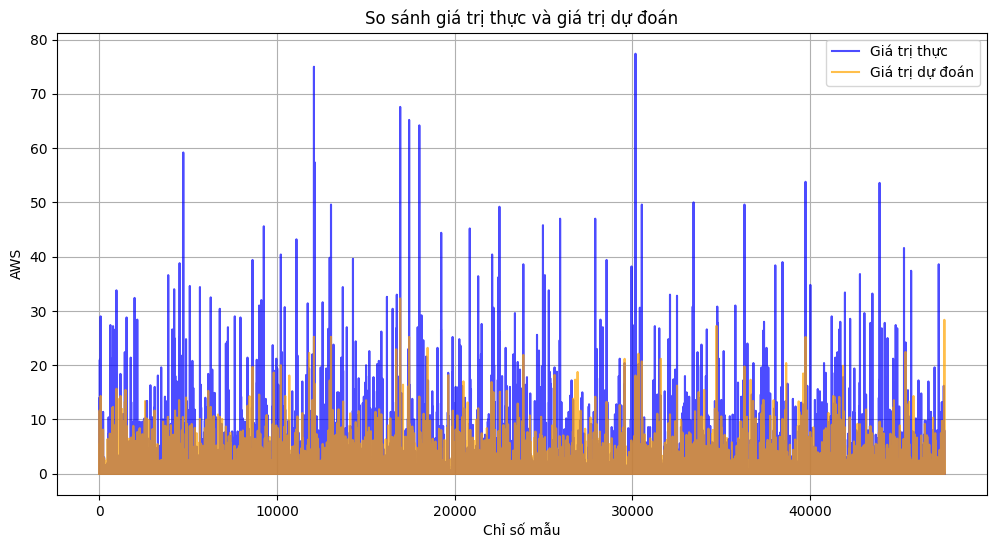

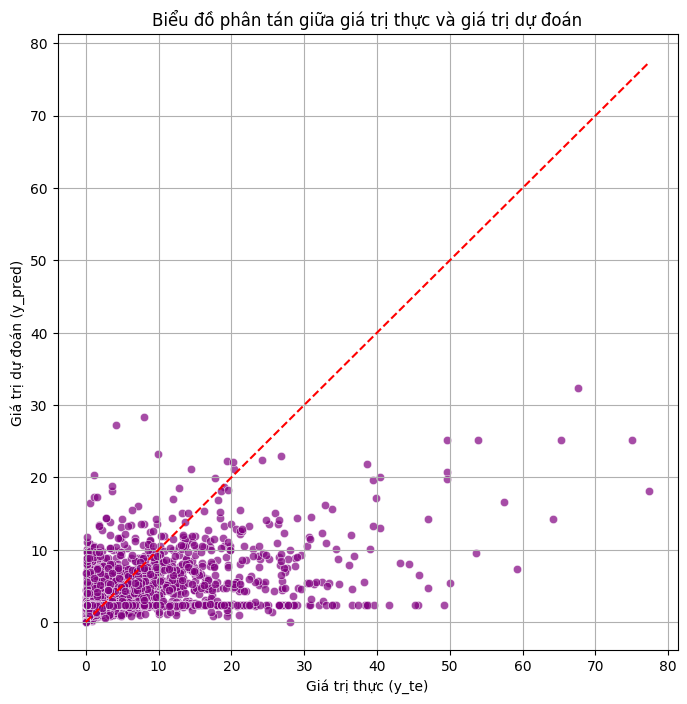

Biểu đồ đường đã được lưu tại: /content/drive/MyDrive/Train AI/save/plots/line_plot.png
Biểu đồ phân tán đã được lưu tại: /content/drive/MyDrive/Train AI/save/plots/scatter_plot.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thư mục lưu trữ trên Google Drive
output_dir = '/content/drive/MyDrive/Train AI/save/plots'
os.makedirs(output_dir, exist_ok=True)

# Vẽ và lưu biểu đồ đường
plt.figure(figsize=(12, 6))
plt.plot(y_te.values, label='Giá trị thực', color='blue', alpha=0.7)
plt.plot(y_pred, label='Giá trị dự đoán', color='orange', alpha=0.7)
plt.title('So sánh giá trị thực và giá trị dự đoán')
plt.xlabel('Chỉ số mẫu')
plt.ylabel('AWS')
plt.legend()
plt.grid(True)
line_plot_path = os.path.join(output_dir, 'line_plot.png')
plt.savefig(line_plot_path, format='png')
plt.show()

# Vẽ và lưu biểu đồ phân tán
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_te.values, y=y_pred.flatten(), alpha=0.7, color='purple')
plt.title('Biểu đồ phân tán giữa giá trị thực và giá trị dự đoán')
plt.xlabel('Giá trị thực (y_te)')
plt.ylabel('Giá trị dự đoán (y_pred)')
plt.plot([min(y_te.values), max(y_te.values)], [min(y_te.values), max(y_te.values)],
         color='red', linestyle='--', linewidth=1.5)  # Đường y=x để so sánh
plt.grid(True)
scatter_plot_path = os.path.join(output_dir, 'scatter_plot.png')
plt.savefig(scatter_plot_path, format='png')
plt.show()

print(f"Biểu đồ đường đã được lưu tại: {line_plot_path}")
print(f"Biểu đồ phân tán đã được lưu tại: {scatter_plot_path}")

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')


In [ ]:
# Load test data
data_test = pd.read_csv('/content/drive/MyDrive/Train AI/test_data.csv')
data_non_null = data_test.dropna()

# Initialize the TabNet model
tabnet_model = TabNetRegressor(cat_idxs=[], cat_dims=[], cat_emb_dim=1)

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

X_test = data_test.drop(columns=['timestamp', 'col', 'row', 'aws'])
y_test = data_test['aws']

# Apply min-max scaling
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Create directory to store model and parameters if it doesn't exist
checkpoint_dir = '/content/drive/MyDrive/Train AI/save/test_tabnet'
os.makedirs(checkpoint_dir, exist_ok=True)

# Predict on the test set (second half of the data)
y_test_pred = data_test.predict(X_test_scaled)

# Calculate RSE and R² for the test set
test_rse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r_squared = r2_score(y_test, y_test_pred)

# Print the results for the test set
print("Test Root Squared Error (RSE):", test_rse)
print("Test R² Score:", test_r_squared)

# Save the best model as a binary object in a .joblib file, then read the contents for writing to the .txt file
combined_path = os.path.join(checkpoint_dir, 'temp_model.joblib')
joblib.dump(tabnet_model, combined_path)

# Append test metrics to the file
with open(combined_path, 'a') as txt_file:
    txt_file.write("\nTest Metrics:\n")
    txt_file.write(f"Test Root Squared Error (RSE): {test_rse}\n")
    txt_file.write(f"Test R² Score: {test_r_squared}\n")


print("Model, parameters, and test metrics have been saved in a .txt file.")
print(f"Combined model and parameters path: {combined_path}")


AttributeError: 'DataFrame' object has no attribute 'predict'

In [ ]:
# Load train data
data_train = pd.read_csv('/content/drive/MyDrive/Train AI/test_data.csv')
data_non_null = data_test.dropna()

# Feature and target separation
X = data_test.drop(columns=['timestamp', 'col', 'row', 'aws'])
y = data_test['aws']

X_scaled = scaler.fit_transform(X)

# Define the parameter grid for random search
#param_grid = {
#    'n_d': np.arange(8, 32, 4),
#    'n_a': np.arange(8, 32, 4),
#    'n_steps': np.arange(3, 10, 1),
#    'gamma': np.linspace(1.0, 2.0, 5),
#    'lambda_sparse': np.logspace(-5, -1, 5)
#}


# Setup RandomizedSearchCV
#random_search = RandomizedSearchCV(
#    estimator=tabnet_model,
#    param_distributions=param_grid,
#    scoring=mae_scorer,
#    cv=KFold(n_splits=2, shuffle=True, random_state=42),
#    n_iter=20,  # Adjust the number of iterations as needed
#    random_state=42,
#    verbose=1,
#    n_jobs=-1
#)

# Fit the RandomizedSearchCV
#random_search.fit(X_scaled, y.values.reshape(-1, 1))

# Best parameters and model
#best_model = random_search.best_estimator_
#best_params = random_search.best_params_
#best_score = random_search.best_score_

#print("Best Parameters:", best_params)
#print("Best Cross-Validated MAE:", -best_score)



with open(combined_path, 'w') as txt_file:
#    # Write the best parameters in a readable format
#    txt_file.write("Best Model Parameters:\n")
#    for param, value in best_params.items():
#        txt_file.write(f"{param}: {value}\n")

#    txt_file.write("\nModel Binary Data:\n")

    # Write the model's binary data as a base64-encoded string
#    with open(temp_model_path, 'rb') as model_file:
#        model_data = model_file.read()
#        txt_file.write(str(model_data))

# Predict on the training set (or any hold-out set if available)
y_pred = tabnet_model.predict(X_scaled)

# Calculate RSE
rse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate R²
r_squared = r2_score(y, y_pred)

# Print the results
print("Root Squared Error (RSE):", rse)
print("R² Score:", r_squared)

# Save RSE and R² in the combined model and parameters file
with open(combined_path, 'a') as txt_file:  # Use 'a' to append to the existing file
    txt_file.write("\nAdditional Metrics:\n")
    txt_file.write(f"Root Squared Error (RSE): {rse}\n")
    txt_file.write(f"R² Score: {r_squared}\n")

# Clean up the temporary .joblib file
os.remove(temp_model_path)

print("Model and parameters have been saved together in a .txt file.")
print(f"Combined model and parameters path: {combined_path}")

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Train AI/dataset.csv')
data_non_null = data.dropna()

# Split dataset into two halves
half_index = len(data_non_null) // 2
first_half_data = data_non_null.iloc[:half_index]

# Feature and target separation for the first half
X = first_half_data.drop(columns=['timestamp', 'col', 'row', 'aws'])
y = first_half_data['aws']


# Apply min-max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Initialize the TabNet model
tabnet_model = TabNetRegressor(cat_idxs=[], cat_dims=[], cat_emb_dim=1)

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Best parameters and model
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validated MAE:", -best_score)

# Create directory to store model and parameters if it doesn't exist
checkpoint_dir = '/content/drive/MyDrive/Train AI/save'
os.makedirs(checkpoint_dir, exist_ok=True)

# Path for the combined model and parameters file
combined_path = os.path.join(checkpoint_dir, 'best_tabnet_model_and_params.txt')

# Save the best model as a binary object in a .joblib file, then read the contents for writing to the .txt file
temp_model_path = os.path.join(checkpoint_dir, 'temp_model.joblib')
joblib.dump(best_model, temp_model_path)

with open(combined_path, 'w') as txt_file:
    # Write the best parameters in a readable format
    txt_file.write("Best Model Parameters:\n")
    for param, value in best_params.items():
        txt_file.write(f"{param}: {value}\n")

    txt_file.write("\nModel Binary Data:\n")

    # Write the model's binary data as a base64-encoded string
    with open(temp_model_path, 'rb') as model_file:
        model_data = model_file.read()
        txt_file.write(str(model_data))

# Predict on the training set (or any hold-out set if available)
y_pred = best_model.predict(X_scaled)

# Calculate RSE
rse = np.sqrt(mean_squared_error(y, y_pred))

# Calculate R²
r_squared = r2_score(y, y_pred)

# Print the results
print("Root Squared Error (RSE):", rse)
print("R² Score:", r_squared)

# Save RSE and R² in the combined model and parameters file
with open(combined_path, 'a') as txt_file:  # Use 'a' to append to the existing file
    txt_file.write("\nAdditional Metrics:\n")
    txt_file.write(f"Root Squared Error (RSE): {rse}\n")
    txt_file.write(f"R² Score: {r_squared}\n")

# Clean up the temporary .joblib file
os.remove(temp_model_path)

print("Model and parameters have been saved together in a .txt file.")
print(f"Combined model and parameters path: {combined_path}")